In [1]:
from utils import METRICS, MODEL_SIZES, sort_and_filter_metrics, CHECKPOINT_STEPS, get_checkpoint_evals, basic_data_sanity_check

import pickle 
import numpy as np
import plotnine as pn
import pandas as pd
import srsly
from pathlib import Path
from transformers import AutoConfig

In [2]:
basic_data_sanity_check()

def compute_explained_variance(S):
    """ For a matrix of singular values, compute the explained variance."""
    variances = S**2 / S.numel()
    explained_variances = variances / np.sum(variances)
    return explained_variances

def compute_condition_number(S, matrix_rank=None):
    """ For a matrix of singular values, compute the condition number."""
    if matrix_rank is None:
        matrix_rank = len(S)
    return S[0] / S[matrix_rank - 1]

def compute_effective_rank(S, matrix_rank):
    """ Compute the effective rank of a matrix as defined by the entropy of the standardized eigenvalues"""
    limited_S = S[:matrix_rank]
    # stand_S = limited_S / limited_S[0]
    stand_S = limited_S / np.linalg.norm(limited_S, ord=1) # Standardize the singular values
    # stand_S = limited_S / np.sum(limited_S) # Standardize the singular values
    return np.exp(-np.sum(stand_S * np.log(stand_S)))/len(stand_S)

In [3]:
data = []
svd_data = []

CIRCUITS = {"mlp": "dense_4h_to_h", "attention": "ov_circuit"}
for model_size in MODEL_SIZES:
    checkpoint_evals = get_checkpoint_evals(model_size)
    model_config = AutoConfig.from_pretrained(f"EleutherAI/pythia-{model_size}-deduped")

    # load svd
    with open(f'/home/rd654/pretraining-playground/computed_statistics/{model_size}/weight_svd_per_layer.pkl', 'rb') as f:
        svd_weights = pickle.load(f)
    
    for circuit_name, circuit_layer in CIRCUITS.items():
        circuit_svd = sort_and_filter_metrics(svd_weights, filter_layer_name=circuit_layer)

        for layer_name, layer_sv in circuit_svd.items():

            i = layer_name.split(".")[2]

            # Iterating over all of the layers 
            matrix_rank = model_config.hidden_size if "dense" in circuit_name else model_config.hidden_size // model_config.num_attention_heads

            # Effective ranks for a given layer over the course of all checkpoints
            effective_ranks = [compute_effective_rank(checkpoint_layer_sv, matrix_rank=matrix_rank) for checkpoint_layer_sv in layer_sv]

            svd_data.append((circuit_name, model_size, CHECKPOINT_STEPS, i, layer_name, matrix_rank, effective_ranks))

    # load metrics
    for metric_name in METRICS:
        with open(f'/home/rd654/pretraining-playground/computed_statistics/{model_size}/{metric_name}_per_layer.pkl', 'rb') as f:
            all_metrics = pickle.load(f)

        for circuit_name, circuit_layer in CIRCUITS.items():
            circuit_metrics = sort_and_filter_metrics(all_metrics, filter_layer_name=circuit_layer, remove_heads=True)
            
            for i, (layer_name, layer_metric) in enumerate(circuit_metrics.items()):
                if metric_name == "grad_weight_magnitudes":
                    layer_metric = np.log(layer_metric)
                data.append((metric_name, circuit_name, model_size, CHECKPOINT_STEPS, i, layer_name, layer_metric))

svd_df = pd.DataFrame(svd_data, columns=["circuit", "model_size", "checkpoint_idx", "layer_idx", "layer", "rank", "effective_rank"])
df = pd.DataFrame(data, columns=["metric", "circuit", "model_size", "checkpoint_idx", "layer_idx", "layer", "value"])

In [4]:
cmap = dict(zip(["70M", "160M", "410M", "1.4B", "2.8B"], ["#003049", "#2a9d8f", "#d62828", "#9b5de5", "#ff9f1c"]))

def process_dataframe(df: pd.DataFrame, explode_col: str) -> pd.DataFrame:
    def as_cat(x: pd.Series) -> pd.Categorical:
        return pd.Categorical(x.tolist(), categories=list(cmap.keys()))

    df = df.explode(["checkpoint_idx", explode_col])
    df = df.convert_dtypes()
    df = df.assign(model_size=lambda _df: as_cat(_df["model_size"].str.upper()))
    return df

df = process_dataframe(df, "value")
svd_df = process_dataframe(svd_df, "effective_rank")

CKA Initial plot

In [36]:
pdata = (
    df
    .query("metric == 'cka_scores'")
    .groupby(["model_size", "circuit", "checkpoint_idx"])
    .agg(
        iqr=('value', lambda x: x.quantile(.75) - x.quantile(.25)),
        q75=('value', lambda x: x.quantile(.75)),
        q25=('value', lambda x: x.quantile(.25)),
        median=('value', lambda x: x.quantile(.5)),
        range=('value', lambda x: x.max() - x.min()),
    )
    .reset_index()
)

pdata = (
    pdata
    # for clarity keep only certain checkpoints
    .query("(checkpoint_idx.isin([0, 1000, 3000])) | (checkpoint_idx >= 10000)")
    # for clarity keep only certain sizes
    .query("(model_size.isin(['160M', '2.8B']))")
    # for clarity keep only certain circuits
    .query("circuit == 'mlp'")
    .assign(model_size=lambda _df: _df["model_size"].astype(str))
)

/tmp/ipykernel_1244467/3107074775.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


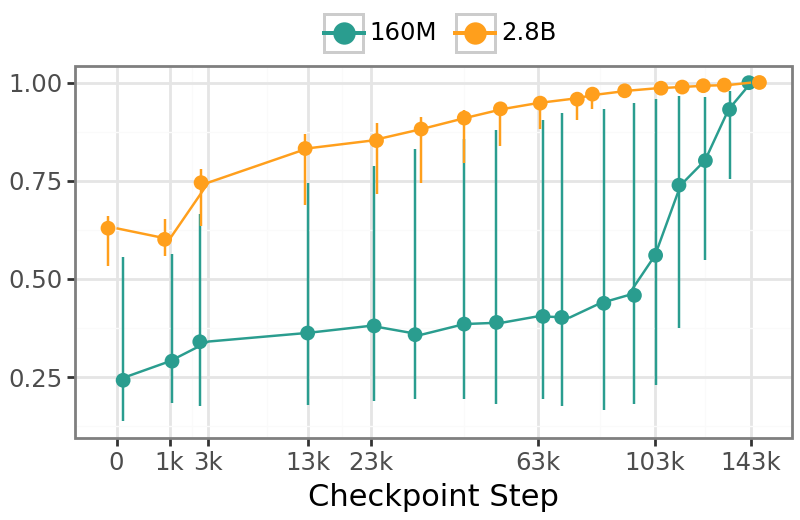

In [43]:
p = (
    pn.ggplot(pdata, pn.aes("checkpoint_idx", "median", ymax="q75", ymin="q25", colour="model_size")) +
    pn.geom_pointrange(position="jitter") +
    pn.geom_line() +
    pn.scale_x_sqrt(
        breaks=[0, 1000, 3000, 13000, 23000, 63000, 103000, 143000],
        labels=lambda x: [f"{v / 1000:.0f}k" if v >= 1000 else f"{v:.0f}" for v in x],
    ) +
    pn.scale_color_manual(values=cmap) +
    pn.labs(x="Checkpoint Step", y="", colour="") +
    pn.theme_bw(base_size=11) +
    pn.theme(plot_margin=0.01, plot_background=None, legend_box_spacing=0.01, legend_box_margin=0, figure_size=(4, 2.6), legend_position="top")
)
p.show()
# p.save("../plots/cka_main_plot.pdf")

CKA all plots

In [ ]:
pdata = (
    df
    .query("metric == 'cka_scores'")
    # for clarity keep only certain checkpoints
    .query("(checkpoint_idx.isin([0, 1000, 3000])) | (checkpoint_idx >= 10000)")
    # .assign(model_size=lambda _df: _df["model_size"].astype(str))
    .assign(circuit=lambda _df: _df["circuit"].map({"attention": "Attention", "mlp": "MLP"}))
)

In [ ]:
p = (
    pn.ggplot(pdata, pn.aes("checkpoint_idx", "value", colour="factor(layer_idx)")) +
    pn.geom_point() +
    pn.geom_line() +
    # pn.facet_grid(cols="circuit") +
    pn.facet_grid(rows="model_size", cols="circuit") +
    pn.scale_x_sqrt(
        breaks=[0, 1000, 3000, 13000, 23000, 63000, 103000, 143000],
        labels=lambda x: [f"{v / 1000:.0f}k" if v >= 1000 else f"{v:.0f}" for v in x],
    ) +
    pn.scale_colour_hue() +
    pn.labs(x="Checkpoint Step", y="", colour="Layer",) +
    pn.theme_bw(base_size=11) +
    pn.theme(plot_margin=0.001, plot_background=None, legend_box_spacing=0.01, legend_box_margin=0, figure_size=(8, 12))
)
p.show()
p.save("../plots/cka_full.pdf")

SVD effective rank

In [58]:
pdata = (
    svd_df
    # for clarity keep only certain checkpoints
    .query("(checkpoint_idx.isin([0, 1000, 3000])) | (checkpoint_idx >= 10000)")
    .assign(circuit=lambda _df: _df["circuit"].map({"attention": "Attention", "mlp": "MLP"}))
)

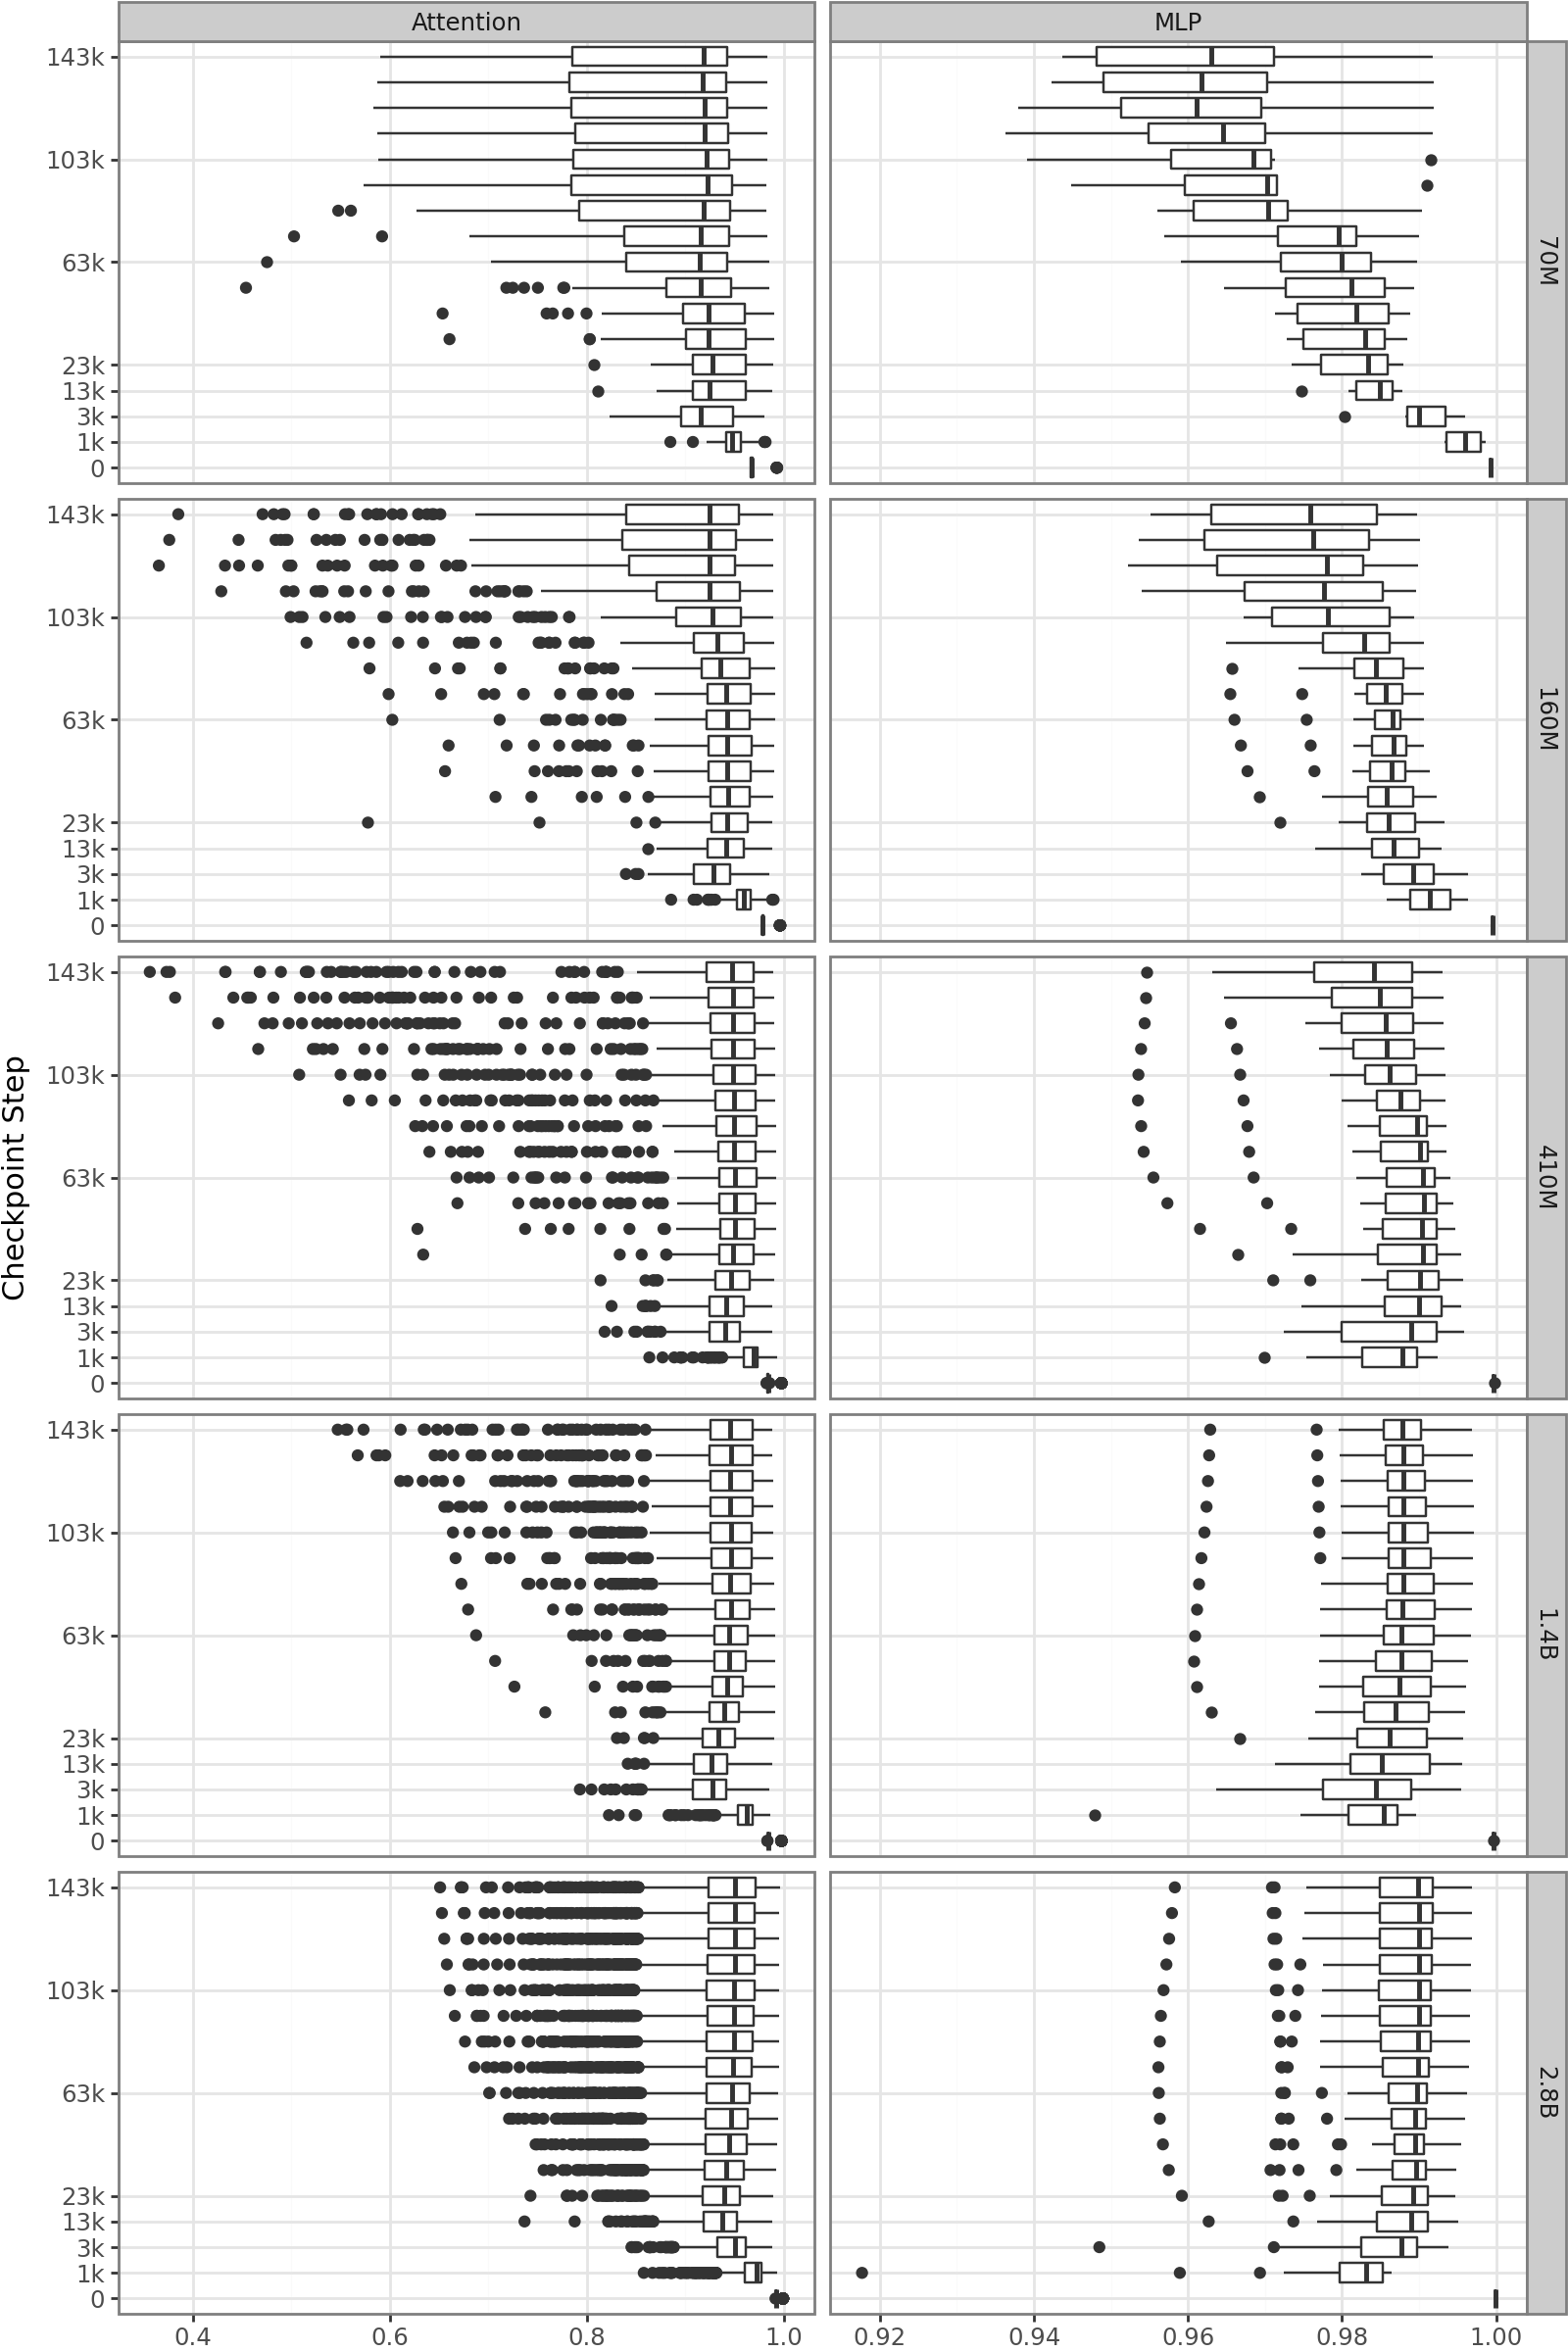

In [60]:
p = (
    pn.ggplot(pdata, pn.aes("factor(checkpoint_idx)", "effective_rank")) +
    pn.geom_boxplot() +
    pn.coord_flip() +
    pn.facet_grid(rows="model_size", cols="circuit", scales="free_x") +
    pn.scale_x_discrete(
        breaks=[0, 1000, 3000, 13000, 23000, 63000, 103000, 143000],
        labels=lambda x: [f"{v / 1000:.0f}k" if v >= 1000 else f"{v:.0f}" for v in x],
    ) +
    pn.scale_colour_hue() +
    pn.labs(x="Checkpoint Step", y="", colour="Layer",) +
    pn.theme_bw(base_size=11) +
    pn.theme(plot_margin=0.001, plot_background=None, legend_box_spacing=0.01, legend_box_margin=0, figure_size=(8, 12))
)
p.show()

In [11]:
pdata = (
    svd_df
    # for clarity keep only certain checkpoints
    .query("(checkpoint_idx.isin([0, 1000, 3000])) | (checkpoint_idx >= 10000)")
    .assign(
        circuit=lambda _df: _df["circuit"].map({"attention": "Attention", "mlp": "MLP"}), 
        layer_idx=lambda _df: _df["layer_idx"].astype(int),
        checkpoint_idx=lambda _df: pd.Categorical(_df, categories=sorted(_df["checkpoint_idx"].unique().tolist()))
    )
    .groupby(["model_size", "checkpoint_idx", "layer_idx", "circuit"])["effective_rank"].median()
    .reset_index()
)

/tmp/ipykernel_1253470/1817084494.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


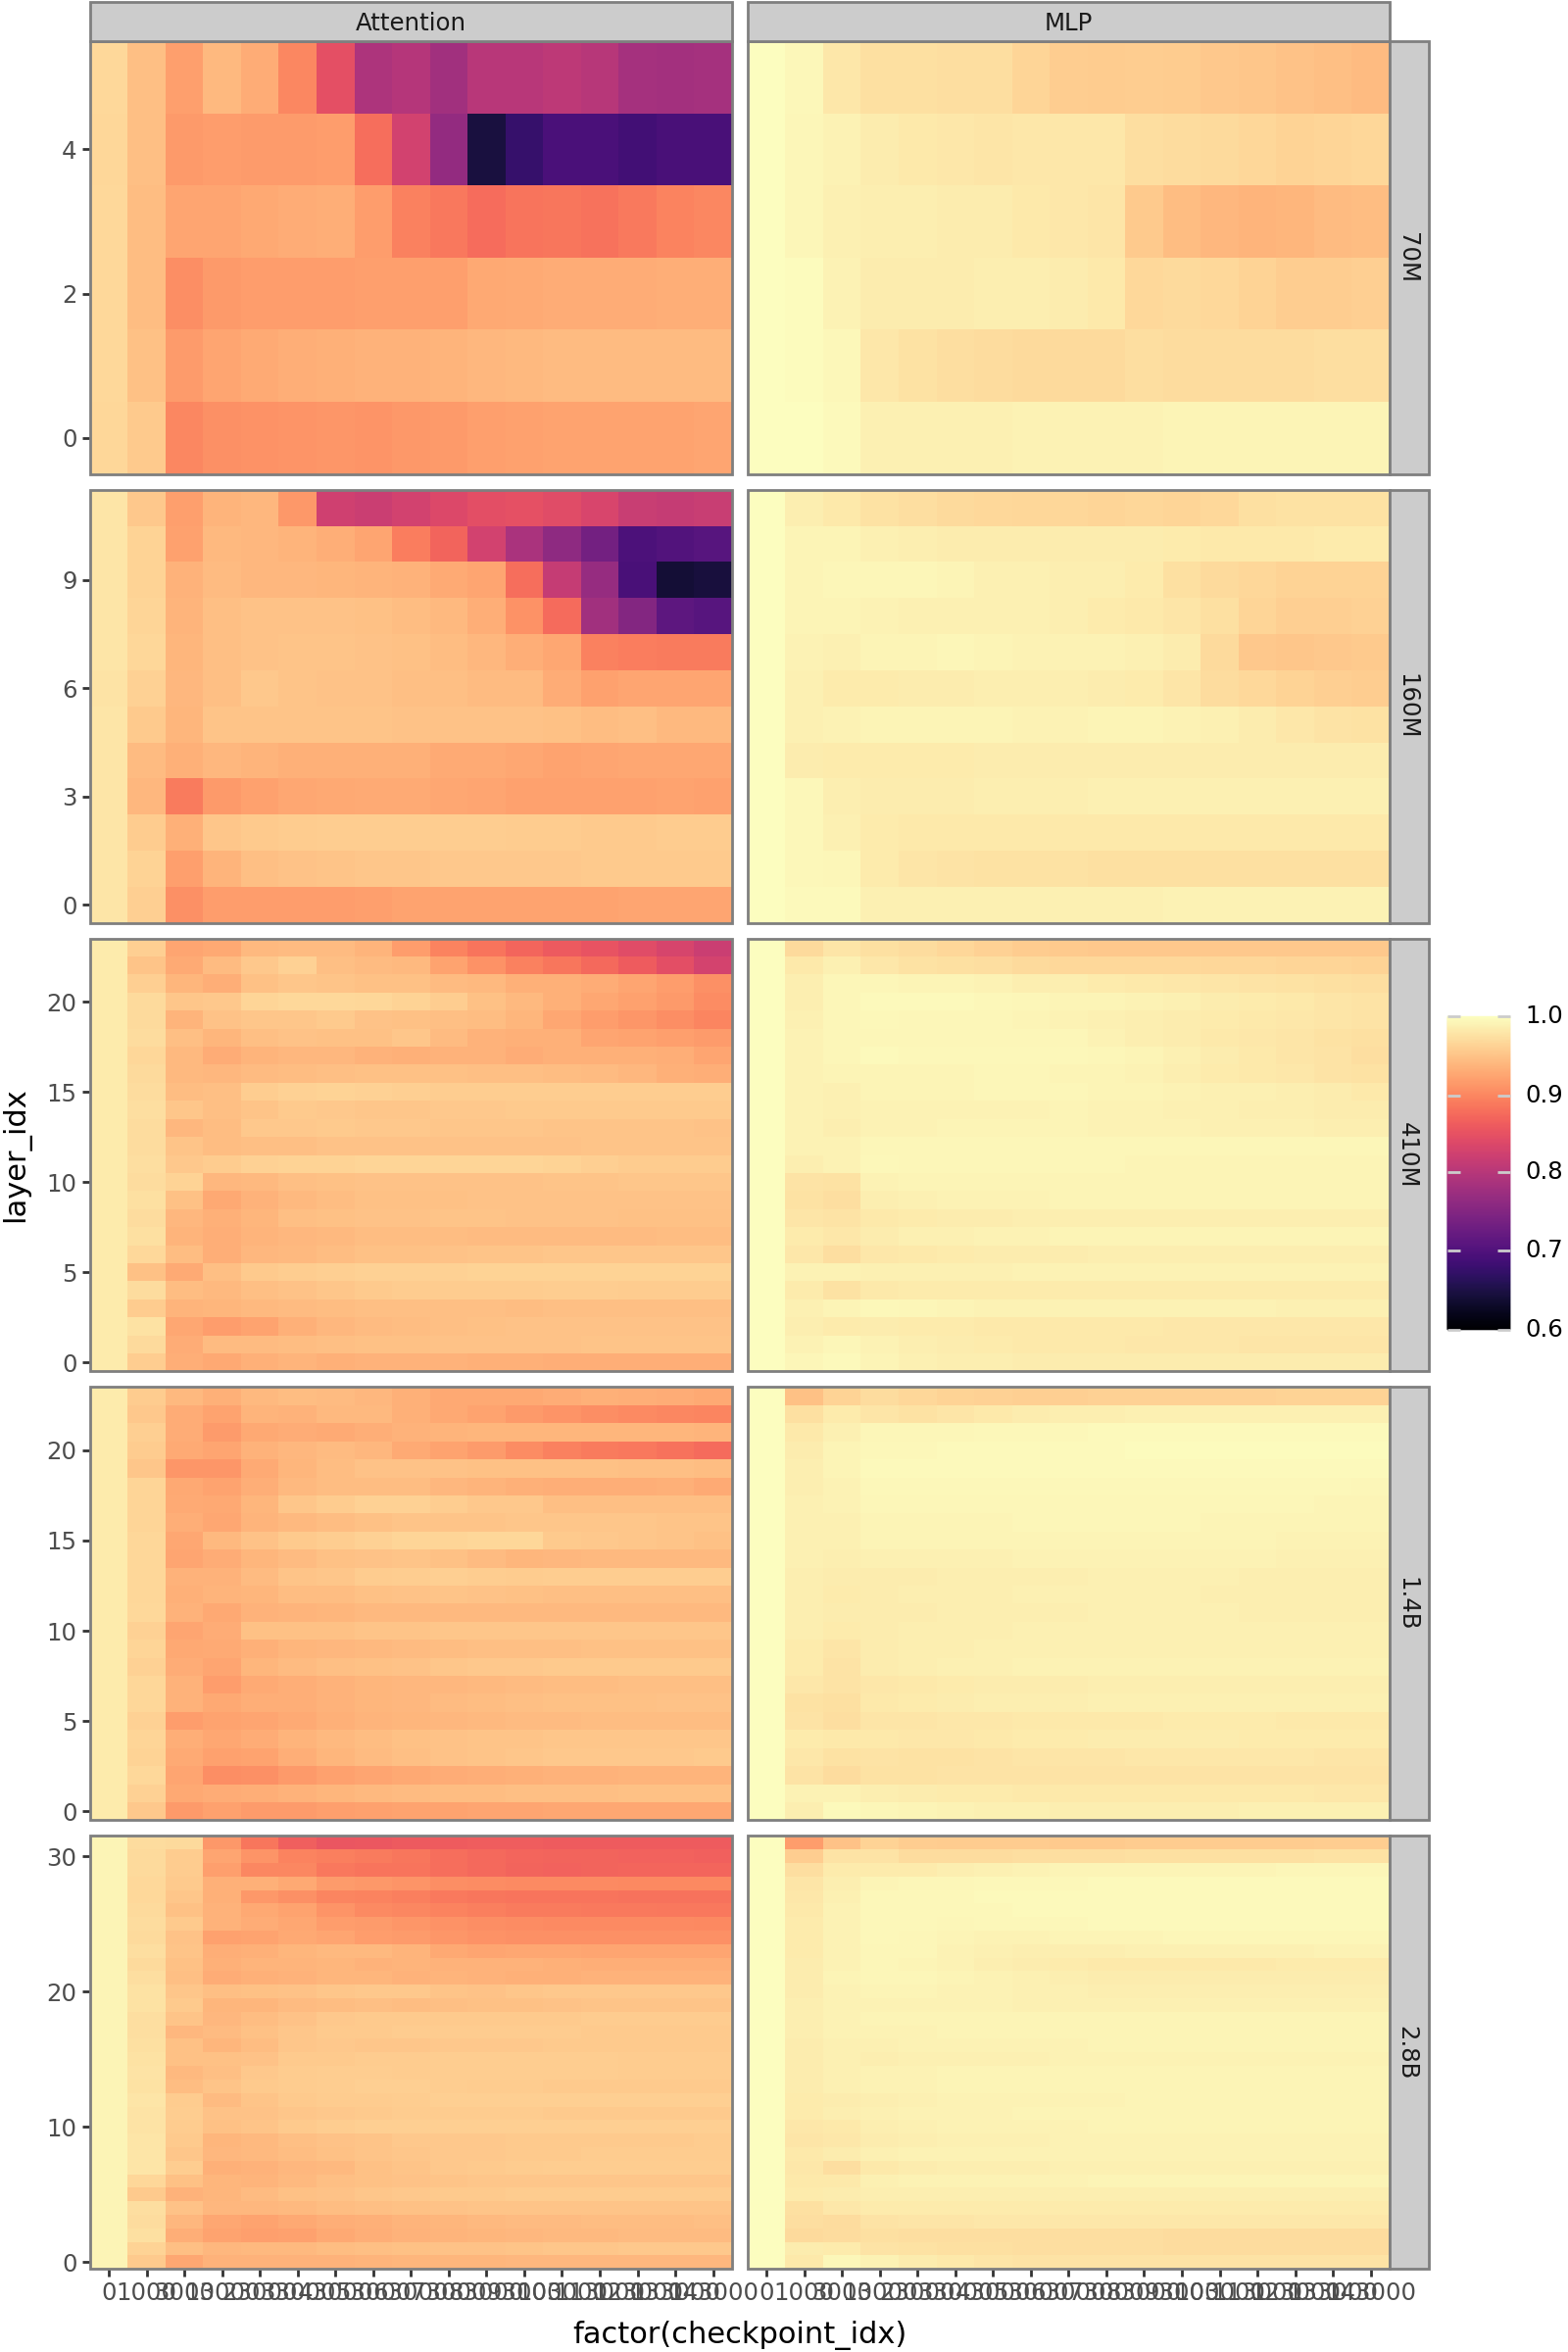

In [18]:
p = (
    pn.ggplot(pdata.dropna(), pn.aes("factor(checkpoint_idx)", "layer_idx", fill="effective_rank")) +
    pn.geom_tile(height=1, colour=None) +
    # pn.facet_grid(cols="circuit") +
    pn.facet_grid(rows="model_size", cols="circuit", scales="free_y") +
    pn.scale_x_discrete(expand=(0, 0)) +
    pn.scale_y_continuous(expand=(0, 0)) +
    pn.scale_fill_continuous(limits=(.6, 1.), cmap_name="magma") +
    pn.labs(fill="") +
    pn.theme_bw(base_size=11) +
    pn.theme(plot_margin=0.001, plot_background=None, legend_box_spacing=0.01, legend_box_margin=0, figure_size=(8, 12))
)
p.show()

In [ ]:
data_path = Path("../pythia/evals/pythia-v1/")

data = []
for p in data_path.rglob("pythia-*-deduped/zero-shot/*.json"):
    ckpt = int(p.name.split("_step")[-1].removesuffix(".json"))
    model_size = p.name.split("-")[0].upper()
    acc = srsly.read_json(p)["results"]["lambada_openai"]["acc"]
    acc_stderr = srsly.read_json(p)["results"]["lambada_openai"]["acc_stderr"]
    data.append((model_size, ckpt, acc, acc_stderr))

eval_df = pd.DataFrame(data, columns=["model_size", "checkpoint_idx", "acc", "acc_stderr"])
eval_df = eval_df.convert_dtypes()

In [ ]:
eval_df

In [ ]:
(
    pn.ggplot(eval_df, pn.aes("checkpoint_idx", "acc", colour="model_size")) +
    pn.geom_point() + 
    pn.geom_line()
)

In [ ]:
df = pd.merge(df, eval_df, on="checkpoint_idx", how="left")

In [ ]:
df.query("model_size==")

In [ ]:
p = (
    pn.ggplot(pdata, pn.aes("checkpoint_idx", "value", colour="factor(layer_idx)")) +
    pn.geom_point() +
    pn.geom_line() +
    pn.scale_x_sqrt(
        # expand=(0, 0), 
        # breaks=[i for i in sorted(pdata["checkpoint_idx"].unique().tolist()) if i < 20000 or i % 40000 == 3000],
        breaks=[0, 1000, 3000, 13000, 23000, 63000, 103000, 143000],
        labels=lambda x: [f"{v / 1000:.0f}k" if v >= 1000 else f"{v:.0f}" for v in x],
    ) +
    # pn.scale_color_manual(values=cmap) +
    # pn.scale_alpha_discrete(guide=None, range=(.5, 1)) +
    # pn.scale_colour_brewer(type="qualitative") +
    pn.scale_colour_hue() +
    pn.labs(x="Checkpoint Step", y="", colour="Layer",) +
    pn.theme_bw(base_size=11) +
    pn.theme(plot_margin=0.001, plot_background=None, legend_box_spacing=0.01, legend_box_margin=0, figure_size=(8, 12))
)
p.show()
p.save("../plots/cka_full.pdf")

In [ ]:
pdata = (
    df.query("(model_size.isin(['160M']))")
    .query("circuit == 'attention'")
)

(
    pn.ggplot(pdata, pn.aes("value", "\acc", colour="factor(layer_idx)")) +
    pn.geom_point() + 
    pn.geom_line()
)